In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
supplier = pd.read_csv('./factset_revere_companies/fs_supplier.csv')
customer = pd.read_csv('./factset_revere_companies/fs_customer.csv')
supplier = supplier.rename({'firm_gvkey': 'target', 'supplier_gvkey': 'source'}, axis=1)[['source', 'target', 'year', 'quarter']]
customer = customer.rename({'firm_gvkey': 'source', 'customer_gvkey': 'target'}, axis=1)[['source', 'target', 'year', 'quarter']]
sc = pd.concat([supplier, customer]).drop_duplicates()

In [3]:
pd.concat([pd.DataFrame(supplier['target'].values), pd.DataFrame(supplier['source'].values), pd.DataFrame(customer['source'].values), pd.DataFrame(customer['target'].values)]).nunique()

0    5807
dtype: int64

In [4]:
# Generating Networks
grouped_data = sc.groupby(['year', 'quarter'])
network_graphs = {}
for (year, quarter), group in grouped_data:
    G = nx.from_pandas_edgelist(group, 'source', 'target', create_using=nx.DiGraph())
    network_graphs[(year, quarter)] = G

In [ ]:
# Plotting Networks
for (year, quarter), graph in network_graphs.items():
    plt.figure(figsize=(20, 20))
    plt.title(f"Supply Chain Network - Year {year}, Quarter {quarter}")
    pos = nx.spring_layout(graph, seed=42)  # You can choose different layout algorithms
    nx.draw(graph, pos, with_labels=True, node_size=10, node_color='skyblue', font_size=8)
    plt.savefig(f"./network_graphs/supply_chain_network_{year}_Q{quarter}.png")
    plt.show()

In [5]:
# Calculating Centrality
centrality = []

for (year, quarter), graph in network_graphs.items():

    degree_centrality = nx.degree_centrality(graph)
    betweenness_centrality = nx.betweenness_centrality(graph)
    closeness_centrality = nx.closeness_centrality(graph)

    for node in graph.nodes:
        centrality.append({
            'year': year,
            'quarter': quarter,
            'node': node,
            'degree_centrality': degree_centrality.get(node, 0),
            'betweenness_centrality': betweenness_centrality.get(node, 0),
            'closeness_centrality': closeness_centrality.get(node, 0)
        })
    print(f'{year}q{quarter} is calculated.')

centrality = pd.DataFrame(centrality)

2006q1 is calculated.
2006q2 is calculated.
2006q3 is calculated.
2006q4 is calculated.
2007q1 is calculated.
2007q2 is calculated.
2007q3 is calculated.
2007q4 is calculated.
2008q1 is calculated.
2008q2 is calculated.
2008q3 is calculated.
2008q4 is calculated.
2009q1 is calculated.
2009q2 is calculated.
2009q3 is calculated.
2009q4 is calculated.
2010q1 is calculated.
2010q2 is calculated.
2010q3 is calculated.
2010q4 is calculated.
2011q1 is calculated.
2011q2 is calculated.
2011q3 is calculated.
2011q4 is calculated.
2012q1 is calculated.
2012q2 is calculated.
2012q3 is calculated.
2012q4 is calculated.
2013q1 is calculated.
2013q2 is calculated.
2013q3 is calculated.
2013q4 is calculated.
2014q1 is calculated.
2014q2 is calculated.
2014q3 is calculated.
2014q4 is calculated.
2015q1 is calculated.
2015q2 is calculated.
2015q3 is calculated.
2015q4 is calculated.
2016q1 is calculated.
2016q2 is calculated.
2016q3 is calculated.
2016q4 is calculated.
2017q1 is calculated.
2017q2 is 

In [34]:
supplier = pd.read_csv('./factset_revere_companies/fs_supplier.csv')
customer = pd.read_csv('./factset_revere_companies/fs_customer.csv')

In [39]:
cc_exposure = pd.concat([supplier[['firm_gvkey', 'firm_pol', 'year', 'quarter']].rename({'firm_gvkey': 'node', 'firm_pol': 'exposure'}, axis=1),
                         customer[['firm_gvkey', 'firm_pol', 'year', 'quarter']].rename({'firm_gvkey': 'node', 'firm_pol': 'exposure'}, axis=1)]).drop_duplicates().dropna()

In [40]:
for (year, quarter), graph in network_graphs.items():
    for node in graph.nodes:
        exposure = cc_exposure[(cc_exposure['node'] == node) & (cc_exposure['year'] == year) & (cc_exposure['quarter'] == quarter)]['exposure'].values
        if len(exposure) > 0:
            graph.nodes[node]['exposure'] = exposure[0]
        else:
            graph.nodes[node]['exposure'] = 0

In [10]:
selected_nodes = []

for graph in network_graphs.values():
    for node in graph.nodes():
        neighbors = list(graph.neighbors(node))
        if len(neighbors) > 0:
            lower_neighbors = [n for n in neighbors if graph.nodes[n]['exposure'] <= graph.nodes[node]['exposure']]
            if len(lower_neighbors) / len(neighbors) > 0.5:
                selected_nodes.append(node)

pd.DataFrame(selected_nodes).drop_duplicates()

AttributeError: 'float' object has no attribute 'nodes'

In [41]:
graph_2021q4 = network_graphs.get((2021, 4))

if graph_2021q4:
    selected_nodes = []
    for node in graph_2021q4.nodes():
        neighbors = list(graph_2021q4.neighbors(node))
        if len(neighbors) > 0:
            lower_neighbors = [n for n in neighbors if graph_2021q4.nodes[n]['exposure'] >= graph_2021q4.nodes[node]['exposure']]
            if len(lower_neighbors) / len(neighbors) == 1:
                selected_nodes.append(node)

pd.DataFrame(selected_nodes).drop_duplicates()

,0
0,28790.0
1,147204.0
2,4060.0
3,2184.0
4,5606.0
...,...
756,62592.0
757,26340.0
758,30398.0
759,23433.0


C:\ProgramData\Anaconda3\lib\site-packages\pygraphviz\agraph.py:1405: RuntimeWarning: Warning: Could not load "C:\ProgramData\Anaconda3\Library\bin\gvplugin_pango.dll" - It was found, so perhaps one of its dependents was not.  Try ldd.

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


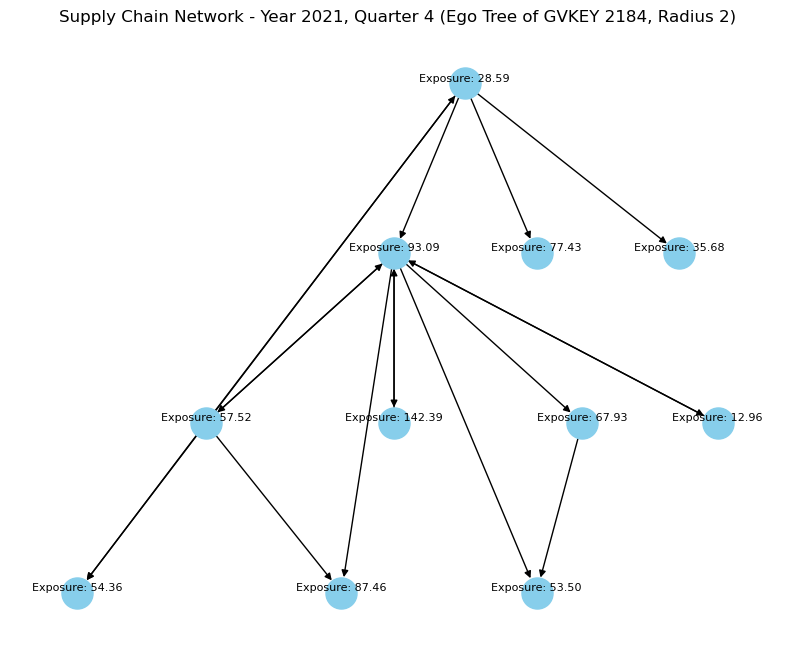

In [49]:
if graph_2021q4:
    target_node = 2184
    radius = 2

    ego_subgraph = nx.ego_graph(graph_2021q4, target_node, radius=radius)

    pos = nx.drawing.layout.kamada_kawai_layout(ego_subgraph, scale=2)

    node_labels = {node: f"Exposure: {ego_subgraph.nodes[node]['exposure']:.2f}" for node in ego_subgraph.nodes()}

    plt.figure(figsize=(10, 8))
    plt.title(f"Supply Chain Network - Year 2021, Quarter 4 (Ego Tree of GVKEY {target_node}, Radius {radius})")
    pos = nx.drawing.nx_agraph.graphviz_layout(ego_subgraph, prog='dot')
    nx.draw(ego_subgraph, pos, node_size=500, font_size=8, node_color='skyblue')
    nx.draw_networkx_labels(ego_subgraph, pos, labels=node_labels, font_size=8, font_color='black', verticalalignment="bottom")
    plt.show()